In [10]:
from google.colab import drive
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

drive.mount('/content/drive')

full_path = '/content/drive/MyDrive/ML Final Project/ML Final Project Data/Raw/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor()
    ])
}

In [12]:
from torchvision import datasets, models, transforms

image_datasets = {x: datasets.ImageFolder(os.path.join(full_path, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=40,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
import pickle

fname = "/content/drive/MyDrive/ML Final Project/models/inception_model_updated2.model"

loaded_model = pickle.load(open(fname, 'rb'))

confusion_matrix = torch.zeros(10, 10)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 99.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,  99.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  88.,   2.,   2.,   5.,   2.,   1.,   0.],
        [  0.,   0.,   0.,  15.,  76.,   2.,   0.,   7.,   0.,   0.],
        [  0.,   0.,   0.,  17.,  21.,  50.,   4.,   6.,   2.,   0.],
        [  0.,   0.,   0.,   3.,   0.,   0.,  92.,   3.,   2.,   0.],
        [  0.,   0.,   0.,  16.,   8.,   0.,  10.,  66.,   0.,   0.],
        [  0.,   0.,   1.,  17.,   2.,   0.,  12.,   4.,  64.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.]])


In [14]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9900, 0.9900, 1.0000, 0.8800, 0.7600, 0.5000, 0.9200, 0.6600, 0.6400,
        1.0000])


Text(0.5, 1.0, 'Confusion Matrix for Test Set')

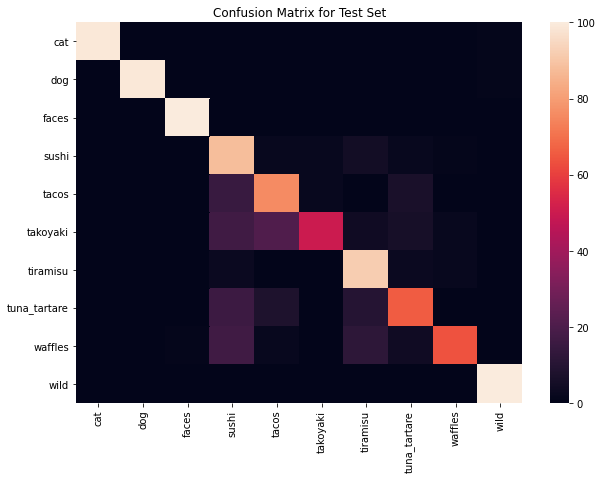

In [15]:
import seaborn as sns

plt.figure(figsize = (10,7))

sns.heatmap(confusion_matrix, xticklabels=class_names, yticklabels=class_names).set_title('Confusion Matrix for Test Set')

In [23]:
import pandas as pd

class_scores = (confusion_matrix.diag()/confusion_matrix.sum(1)).detach().numpy()
print(class_scores)
print(class_names)

class_breakdown = pd.DataFrame(class_scores, class_names)

print(class_breakdown)

[0.99 0.99 1.   0.88 0.76 0.5  0.92 0.66 0.64 1.  ]
['cat', 'dog', 'faces', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles', 'wild']
                 0
cat           0.99
dog           0.99
faces         1.00
sushi         0.88
tacos         0.76
takoyaki      0.50
tiramisu      0.92
tuna_tartare  0.66
waffles       0.64
wild          1.00
